# Práctico librería implicit - ALS y BPR

Clase: IIC3633 Sistemas Recomendadores, PUC Chile

En este práctico vamos a utilizar la biblioteca de Python [implicit](https://implicit.readthedocs.io/en/latest/quickstart.html) para recomendación utilizando ALS y BPR. 


In [8]:
!curl -L -o "u2.base" "https://drive.google.com/uc?export=download&id=1bGweNw7NbOHoJz11v6ld7ymLR8MLvBsA"
!curl -L -o "u2.test" "https://drive.google.com/uc?export=download&id=1f_HwJWC_1HFzgAjKAWKwkuxgjkhkXrVg"
!curl -L -o "u.item" "https://drive.google.com/uc?export=download&id=10YLhxkO2-M_flQtyo9OYV4nT9IvSESuz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    414      0 --:--:-- --:--:-- --:--:--   413
100 1546k  100 1546k    0     0  1157k      0  0:00:01  0:00:01 --:--:--  100M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    639      0 --:--:-- --:--:-- --:--:--   639
100  385k  100  385k    0     0   395k      0 --:--:-- --:--:-- --:--:--  188M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    456      0 --:--:-- --:--:-- --:--:--   456
100  230k  100  230k    0     0   197k      0  0:00:01  0:00:01 --:--:--  761k


In [2]:
!pip3 install implicit --upgrade

     |████████████████████████████████| 1.1MB 10.2MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp36-cp36m-linux_x86_64.whl size=3419421 sha256=8320c344ddea90130253b91d2748487ea82952a6539b02d520d4daa71c796b92
  Stored in directory: /root/.cache/pip/wheels/bf/d4/ec/fd4f622fcbefb7521f149905295b2c26adecb23af38aa28217
Successfully built implicit


In [26]:
import pandas as pd
import numpy as np
import implicit
import scipy.sparse as sparse
import matplotlib.pyplot as plt


In [10]:
columns = ['movieid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [11]:
# Primero creamos el dataframe con los datos
df_train = pd.read_csv('u2.base',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)

# rating >= 3 , relevante (1) y rating menor a 3 es no relevante (0)
df_train.rating = [1 if x >=3 else 0 for x in df_train.rating ]

In [12]:
df_train.head()

,userid,itemid,rating,timestamp
0,1,3,1,878542960
1,1,4,1,876893119
2,1,5,1,889751712
3,1,6,1,887431973
4,1,7,1,875071561


In [13]:
# Cargamos el dataset con los items
df_items = pd.read_csv('u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None, 
                        encoding='latin-1')

In [14]:
df_items.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [15]:
# Cargamos el dataset de testing
df_test = pd.read_csv('u2.test',
                      sep='\t',
                      names=['userid', 'itemid', 'rating', 'timestamp'],
                      header=None)


# rating >= 3 es relevante (1) y rating menor a 3 es no relevante (0) 
df_test.rating = [1 if x >=3 else 0 for x in df_test.rating ]


user_items_test = {}

for row in df_test.itertuples():
    if row[1] not in user_items_test:
        user_items_test[row[1]] = []
        
    user_items_test[row[1]].append(row[2])

In [16]:
df_test.head()

,userid,itemid,rating,timestamp
0,1,1,1,874965758
1,1,2,1,876893171
2,1,8,0,875072484
3,1,9,1,878543541
4,1,21,0,878542772


### Métricas

In [17]:
# Definicion de métricas (No editar)
# Obtenido de https://gist.github.com/bwhite/3726239

def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])
  
def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.


def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)

    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

### Preprocesamiento de los datos a formato sparse

In [18]:
user_items = {}
itemset = set()

for row in df_train.itertuples():
    if row[1] not in user_items:
        user_items[row[1]] = []
        
    user_items[row[1]].append(row[2])
    itemset.add(row[2])

itemset = np.sort(list(itemset))

sparse_matrix = np.zeros((len(user_items), len(itemset)))

for i, items in enumerate(user_items.values()):
    sparse_matrix[i] = np.isin(itemset, items, assume_unique=True).astype(int)
    
matrix = sparse.csr_matrix(sparse_matrix.T)

user_ids = {key: i for i, key in enumerate(user_items.keys())}
user_item_matrix = matrix.T.tocsr()

In [19]:
def evaluate_model(model, n):
  mean_map = 0.
  mean_ndcg = 0.
  for u in user_items_test.keys():
    rec = [t[0] for t in model.recommend(u, user_item_matrix, n)]
    rel_vector = [np.isin(user_items_test[u], rec, assume_unique=True).astype(int)]
    mean_map += mean_average_precision(rel_vector)
    mean_ndcg += ndcg_at_k(rel_vector, n)

  mean_map /= len(user_items_test)
  mean_ndcg /= len(user_items_test)
  
  return mean_map, mean_ndcg

In [20]:
def show_recommendations(model, user, n):
  recommendations = [t[0] for t in model.recommend(user, user_item_matrix, n)]
  return df_items.loc[recommendations]['title']

In [21]:
def show_similar_movies(model, item, n=10):
  sim_items = [t[0] for t in model.similar_items(item, n)]
  return df_items.loc[sim_items]['title']

## ALS (Implicit Feedback)

**Pregunta 1:** Explique brevemente cómo funciona el algoritmo ALS.

**Respuesta:** El algoritmo ALS tambien es un modelo de factorización matricial al igual que SVD que busca encontrar la mejor representación de los usuarios e items mediantes factores latentes. Lo especial de este algoritmo es la forma en que se entrena. En cada iteración una de las dos matrices (item o usuario) se mantiene constante y la otra actualiza sus factores mediante mínimos cuadrados. Posteriormente se alterna, fijando la otra matriz y actualizando aquella que en la iteración previa se mantuvo constante.

In [16]:
# Definimos y entrenamos el modelo con optimización ALS
model_als = implicit.als.AlternatingLeastSquares(factors=100, iterations=10, use_gpu=False)
model_als.fit(matrix)

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

In [17]:
show_recommendations(model_als, user=77, n=10)

movieid
256     When the Cats Away (Chacun cherche son chat) (...
258                                        Contact (1997)
292                                       Rosewood (1997)
409                                           Jack (1996)
273                                           Heat (1995)
257                                   Men in Black (1997)
754                                     Red Corner (1997)
49                                            I.Q. (1994)
1012                                 Private Parts (1997)
125                                     Phenomenon (1996)
Name: title, dtype: object

In [18]:
maprec, ndcg = evaluate_model(model_als, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.06580323460824943
ndcg: 0.3537519142419602


**Pregunta 2:** Pruebe distintos valores para los parámetros de ALS y muestre gráficos de cómo se ven afectadas las métricas recién mostradas.

In [24]:
# Ejemplo
factor_values = [64, 128, 192, 256, 320, 384, 448, 512] # definir distintos numeros de factores
map_values = [] # para almacenar resultados de MAP
ndcg_values = [] # para almacenar valores de NDCG

for f in factor_values:
  # Definimos y entrenamos el modelo con optimización ALS
  model_als = implicit.als.AlternatingLeastSquares(factors=f, iterations=10, use_gpu=True)
  model_als.fit(matrix)

  maprec, ndcg = evaluate_model(model_als, n=10)
  
  map_values.append(maprec)
  ndcg_values.append(ndcg)

print(map_values)
print(ndcg_values)


[0.020737567148300114, 0.014409020907074086, 0.016187082867253677, 0.0187841894968017, 0.013573143174792229, 0.016658733871929107, 0.034704473998880554, 0.022522493679930703]
[0.1669218989280245, 0.10566615620214395, 0.13782542113323124, 0.14088820826952528, 0.1562021439509954, 0.17304747320061256, 0.2082695252679939, 0.1776416539050536]


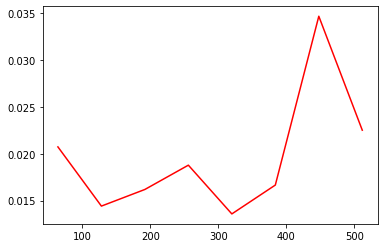

In [27]:
plt.plot(factor_values, map_values, 'r-')
plt.show()

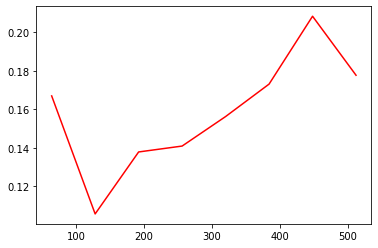

In [28]:
plt.plot(factor_values, ndcg_values, 'r-')
plt.show()

In [30]:
# Ejemplo
iterations = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100] # definir distintos numeros de factores
map_values = [] # para almacenar resultados de MAP
ndcg_values = [] # para almacenar valores de NDCG

for i in iterations:
  # Definimos y entrenamos el modelo con optimización ALS
  model_als = implicit.als.AlternatingLeastSquares(factors=448, iterations=i, use_gpu=True)
  model_als.fit(matrix)

  maprec, ndcg = evaluate_model(model_als, n=10)
  
  map_values.append(maprec)
  ndcg_values.append(ndcg)

print(map_values)
print(ndcg_values)


[0.020183350238151914, 0.016207914538956352, 0.009330023555899751, 0.021177598572602305, 0.018050306616991293, 0.028262929361566623, 0.016915204901667456, 0.006334151453401827, 0.009330081333213577, 0.01099088858949723]
[0.14854517611026033, 0.14088820826952528, 0.1362940275650842, 0.17457886676875958, 0.15313935681470137, 0.15926493108728942, 0.15926493108728942, 0.10260336906584992, 0.12404287901990811, 0.15160796324655437]


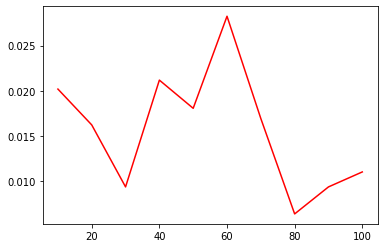

In [32]:
plt.plot(iterations, map_values, 'r-')
plt.show()

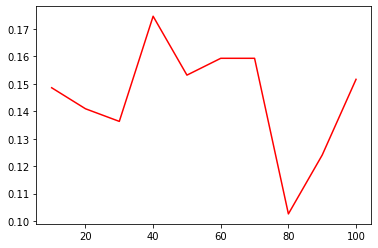

In [34]:
plt.plot(iterations, ndcg_values, 'r-')
plt.show()

In [35]:
# Ejemplo
regul = [0.1, 0.01, 0.001] # definir distintos numeros de factores
map_values = [] # para almacenar resultados de MAP
ndcg_values = [] # para almacenar valores de NDCG

for r in regul:
  # Definimos y entrenamos el modelo con optimización ALS
  model_als = implicit.als.AlternatingLeastSquares(factors=448, iterations=40, use_gpu=True, regularization=r)
  model_als.fit(matrix)

  maprec, ndcg = evaluate_model(model_als, n=10)
  
  map_values.append(maprec)
  ndcg_values.append(ndcg)

print(map_values)
print(ndcg_values)


[0.00937253347664816, 0.022251378591840246, 0.007590957913134771]
[0.11944869831546708, 0.15313935681470137, 0.14854517611026033]


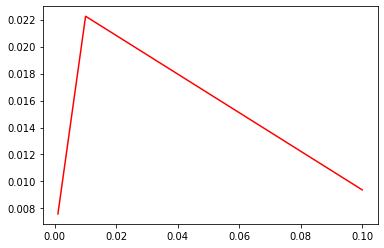

In [36]:
plt.plot(regul, map_values, 'r-')
plt.show()

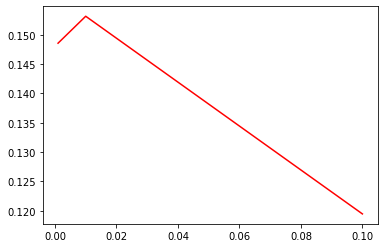

In [37]:
plt.plot(regul, ndcg_values, 'r-')
plt.show()

La mejor configuración de las pruebas es la siguiente:



In [40]:
# Definimos y entrenamos el modelo con optimización ALS
model_als = implicit.als.AlternatingLeastSquares(factors=448, iterations=40, use_gpu=True, regularization=0.01)
model_als.fit(matrix)

maprec, ndcg = evaluate_model(model_als, n=10)
print(maprec, ndcg)
show_recommendations(model_als, user=77, n=10)


0.019846188397002258 0.20367534456355282


movieid
20                              Angels and Insects (1995)
403                                         Batman (1989)
366                                Dangerous Minds (1995)
672                                       Candyman (1992)
256     When the Cats Away (Chacun cherche son chat) (...
290                               Fierce Creatures (1997)
1509                         Getting Even with Dad (1994)
104                                   Theodore Rex (1995)
595                                       Fan, The (1996)
393                                 Mrs. Doubtfire (1993)
Name: title, dtype: object

## BPR

**Pregunta 3:** Explique con sus palabras la intuición del framework BPR.


BPR se basa en entrenamiento donde se busca modelar una relación de orden de preferencia entre los ítems. Para ello se entrena con triplets (usuario, item1, item2) de modo de ordenar cual ítem tiene más preferencia por sobre el otro.  

In [41]:
# Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=400, iterations=40, use_gpu=False)
model_bpr.fit(matrix)

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

In [42]:
show_recommendations(model_bpr, user=77, n=10)

movieid
257                               Men in Black (1997)
299                                    Hoodlum (1997)
285                             Secrets & Lies (1996)
327                                   Cop Land (1997)
244                     Smilla's Sense of Snow (1997)
332                             Kiss the Girls (1997)
300                              Air Force One (1997)
312    Midnight in the Garden of Good and Evil (1997)
676                              Crucible, The (1996)
99             Snow White and the Seven Dwarfs (1937)
Name: title, dtype: object

In [43]:
show_similar_movies(model_bpr, item=171, n=10)

movieid
171                Delicatessen (1991)
78                   Free Willy (1993)
172    Empire Strikes Back, The (1980)
173         Princess Bride, The (1987)
209          This Is Spinal Tap (1984)
68                    Crow, The (1994)
203                  Unforgiven (1992)
201                Evil Dead II (1987)
21       Muppet Treasure Island (1996)
167            Private Benjamin (1980)
Name: title, dtype: object

In [44]:
maprec, ndcg = evaluate_model(model_bpr, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.06001891307504606
ndcg: 0.36447166921898927


**Pregunta 4:** Pruebe distintos valores para los parámetros de BPR y muestre gráficos de cómo se ven afectadas las métricas de ranking (nDCG@10 y MAP) recién mostradas.

In [52]:
# Ejemplo
factor_values = [63, 127, 191, 255, 319, 383, 447, 511] # definir distintos numeros de factores
map_values = [] # para almacenar resultados de MAP
ndcg_values = [] # para almacenar valores de NDCG

for f in factor_values:
  # Definimos y entrenamos el modelo con optimización ALS
  model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=f, iterations=40, use_gpu=True)
  model_bpr.fit(matrix)

  maprec, ndcg = evaluate_model(model_bpr, n=10)
  
  map_values.append(maprec)
  ndcg_values.append(ndcg)

print(map_values)
print(ndcg_values)


[0.009726870893823828, 0.02181394223921472, 0.019643598707168527, 0.013289527839356467, 0.09569751725925095, 0.009631050635252733, 0.005824765768512519, 0.008363578426162643]
[0.14241960183767227, 0.14701378254211334, 0.14854517611026033, 0.12557427258805512, 0.2082695252679939, 0.16079632465543645, 0.11638591117917305, 0.08116385911179173]


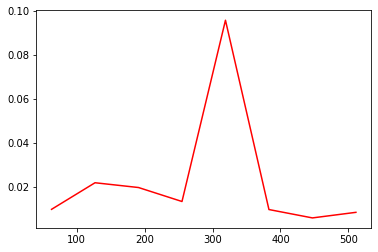

In [53]:
plt.plot(factor_values, map_values, 'r-')
plt.show()

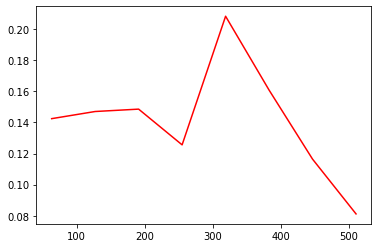

In [54]:
plt.plot(factor_values, ndcg_values, 'r-')
plt.show()

In [55]:
# Ejemplo
iterations = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100] # definir distintos numeros de factores
map_values = [] # para almacenar resultados de MAP
ndcg_values = [] # para almacenar valores de NDCG

for i in iterations:
  # Definimos y entrenamos el modelo con optimización ALS
  model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=319, iterations=i, use_gpu=True)
  model_bpr.fit(matrix)

  maprec, ndcg = evaluate_model(model_bpr, n=10)
  
  map_values.append(maprec)
  ndcg_values.append(ndcg)

print(map_values)
print(ndcg_values)


[0.011788486868882656, 0.020253923194772528, 0.032970209104088904, 0.009049588303719413, 0.01021638444587168, 0.009330943930232155, 0.010536141643732068, 0.005625648393596284, 0.018971688084566098, 0.02230843017910249]
[0.09494640122511486, 0.21286370597243492, 0.18376722817764166, 0.11332312404287902, 0.16539050535987748, 0.11791730474732007, 0.09494640122511486, 0.11944869831546708, 0.15773353751914243, 0.13935681470137826]


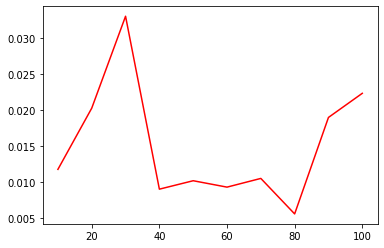

In [56]:
plt.plot(iterations, map_values, 'r-')
plt.show()

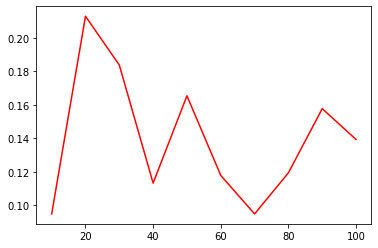

In [57]:
plt.plot(iterations, ndcg_values, 'r-')
plt.show()

In [58]:
# Ejemplo
regul = [0.1, 0.01, 0.001] # definir distintos numeros de factores
map_values = [] # para almacenar resultados de MAP
ndcg_values = [] # para almacenar valores de NDCG

for r in regul:
  # Definimos y entrenamos el modelo con optimización ALS
  model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=319, iterations=20, use_gpu=True, regularization=r)
  model_bpr.fit(matrix)

  maprec, ndcg = evaluate_model(model_bpr, n=10)
  
  map_values.append(maprec)
  ndcg_values.append(ndcg)

print(map_values)


[0.017136695974257342, 0.05906381959326145, 0.03284401196174391]


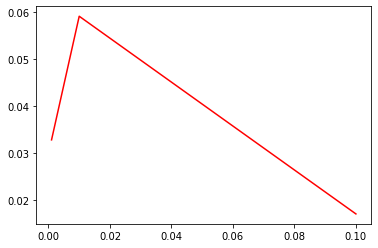

In [59]:
plt.plot(regul, map_values, 'r-')
plt.show()

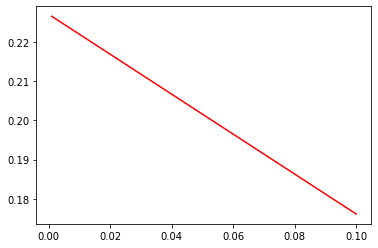

In [60]:
plt.plot(regul, ndcg_values, 'r-')
plt.show()

Mejores parámetros

In [61]:
model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=319, iterations=20, use_gpu=True, regularization=0.01)
model_bpr.fit(matrix)

maprec, ndcg = evaluate_model(model_bpr, n=10)

In [62]:
print(maprec)
print(ndcg)

0.05886308791555044
0.20673813169984687
